# Met Office WOW Exploration

![JCEEI logo](../jceei_logo.png)
______________________________________________________________________

In this notebook, data from [WOW](https://www.wow.metoffice.gov.uk/) (The service acting as the point of access for crowd sourced recent and historical weather observations) is explored through various plots that visualize the data. The tools used for exploration and plotting are: [Matplotlib](https://matplotlib.org/), and [Pandas](https://pandas.pydata.org)

### Prerequisites

To follow along with this notebook, data from [WOW](https://www.wow.metoffice.gov.uk/) must be downloaded, the general steps for doing so are as follows:

- Create an account on [WOW](https://www.wow.metoffice.gov.uk/) and log in
- Find desired sites and make sure the site reports desired parameter data during desired time selection viewable in the tables tab within the specific site view
- Download site [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) data using the export function (which export only appears once logged in)
- Place the downloaded data in the relevant directory

## Contents

- Explore [WOW](https://www.wow.metoffice.gov.uk/) Data
  - Single Site
    - Load in Pre-Downloaded Data
    - Format and Explore the Data
      - Show Data Issue: Missing Observations
    - Plot the Data with Rolling Mean for Averages (which is an incorrect implementation due to missing data)
  - Multi Site
    - Load and Merge Data
      - Ensure no Duplicate Data has been Loaded
    - Plot Multi Site Information
      - (Optionally use [DataHub](https://metoffice.apiconnect.ibmcloud.com/metoffice/production/) to yield closest Met Office Observational Site Name)
    - Prune Data to Leave Desired Data
    - Plot Desired Data as a Whole (Messy)
    - Separate Data by Month per Site
    - Plot All Sites on a Separate plot for each Month (Cleaner)

In [2]:
# import required packages
import datetime
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In the case of this notebook, the single site data is data downloaded for the entire year of 2021 and the multi site data is downloaded from 4 months across the year of 2019. This information is used in generating the glob patterns below, and should be changed if the data is different to this.

In [3]:
# DEFINE NOTEBOOK SETTINGS
wow_download_dir = "data/WOW"
glob_pattern_for_single_site_data = wow_download_dir + "/*/*2021.csv"
multi_site_glob_pattern = wow_download_dir + "/*/*2019.csv"

# If this setting does not work, either disable the setting, or successfully get through
# the datahub tutorial
PLOT_SITE_NAMES_MAP = True


if PLOT_SITE_NAMES_MAP:
    import cartopy.crs as ccrs
    import requests

    # clear cell outputs when private API keys are displayed
    from IPython.display import clear_output

    # read environment file
    env_vars = {}

    with open(".env") as f:
        for line in f:
            key, value = line.strip().split("=", 1)
            env_vars[key] = value

    SITE_ID = env_vars["SITE_SPECIFIC_CLIENT_ID"]
    SITE_SECRET = env_vars["SITE_SPECIFIC_CLIENT_SECRET"]
    spot_data_headers = {
        "X-IBM-Client-Id": SITE_ID,
        "X-IBM-Client-Secret": SITE_SECRET,
    }
    
ZENODO_RECORD = 'https://zenodo.org/record/7104836'
DOWNLOAD_FROM_ZENODO = True
FILE_SAVE_PATH = './data/WOW'
if DOWNLOAD_FROM_ZENODO:
    from bs4 import BeautifulSoup
    import re
    import json
    from io import BytesIO

## Autodownload the data (check above notebook settings, won't download if multi-site files are downloaded)

In [4]:
if DOWNLOAD_FROM_ZENODO:
    if len(glob.glob(multi_site_glob_pattern)) == 0:
        r = requests.get(ZENODO_RECORD)
        # print(r.content)
        soup = BeautifulSoup(
                r.content, "html.parser"
            ) 
        data_json = soup.find_all(string=re.compile("DataDownload"))
        data_json = json.loads(data_json[0])
        download_links = list(data["contentUrl"] for data in data_json['distribution'] if data["@type"] == "DataDownload")
        print("Downloading from web:\n", json.dumps(download_links, indent=4))
        file_object_list = []
        for get_link in download_links:
            r = requests.get(get_link)
            csv = BytesIO(r.content)
            df = pd.read_csv(csv, index_col=0)
            file_object_list.append(df)
        print("Saving to disk...")
        for df in file_object_list:
            site_id = df['Site Id'].loc[0]
            year_taken = df['Report Date / Time'].loc[0][0:4]
            subdir = 'multi_site_2019' if year_taken=='2019' else 'single_site_2021'
            df.to_csv(f'{FILE_SAVE_PATH}/{subdir}/{site_id}_{year_taken}.csv')
        print("Download complete")
        del df # remove df var to prevent confusion in df var of later cells
    else:
        print("Files already exist")

Files already exist


## Site specific observational data from WOW

### 2021 Whole year, Single Site

#### Load in Pre-Downloaded Data

In [5]:
# define download paths for single site data

csv_files = glob.glob(glob_pattern_for_single_site_data)
print(csv_files)

['data/WOW/single_site_2021/927706001_2021.csv']


In [6]:
# load and save data to a list per file
list_of_dfs_from_csv = []
for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    list_of_dfs_from_csv.append(df)

In [7]:
# show file number
print(len(list_of_dfs_from_csv))

1


In [8]:
# concatenate all data and display the resulting dataframe
df = pd.concat(list_of_dfs_from_csv)
df

Unnamed: 0                                   Id    Site Id  Longitude  \
0              0  ﻿20210101xc6kffkm3ye6zd9pyyb96spf9y  927706001       -3.9   
1              1   202101015iwnnm1m4ye6zd9pyyb96spf9y  927706001       -3.9   
2              2   2021010184hssk1m5re6zd9pyyb96spf9y  927706001       -3.9   
3              3   20210101wnhdxd1mhre6zd9pyyb96spf9y  927706001       -3.9   
4              4   20210101yjkyq9nm7ee6zd9pyyb96spf9y  927706001       -3.9   
...          ...                                  ...        ...        ...   
8121        8121   20211231puyh9ymkxye63qbyyyb96smuyy  927706001       -3.9   
8122        8122   20211231334tei5koye63qbyyyb96smuyy  927706001       -3.9   
8123        8123   2021123158u6qfmkoye63qbyyyb96smuyy  927706001       -3.9   
8124        8124   20211231g33n6uuktre63qbyyyb96smuyy  927706001       -3.9   
8125        8125   20211231ubmodjuk1re63qbyyyb96smuyy  927706001       -3.9   

      Latitude   Report Date / Time  Air Temperature  Wet Bulb  Dew Point  \
0       50.767           2021-01-01             -2.2       NaN       -2.5   
1       50.767  2021-01-01 01:00:00             -3.1       NaN       -3.4   
2       50.767  2021-01-01 02:00:00             -4.1       NaN       -4.5   
3       50.767  2021-01-01 03:00:00             -2.2       NaN       -2.3   
4       50.767  2021-01-01 04:00:00             -1.0       NaN       -1.3   
...        ...                  ...              ...       ...        ...   
8121    50.767  2021-12-31 19:00:00             13.1       NaN       11.4   
8122    50.767  2021-12-31 20:00:00             13.0       NaN       11.7   
8123    50.767  2021-12-31 21:00:00             13.1       NaN       11.4   
8124    50.767  2021-12-31 22:00:00             13.7       NaN       10.0   
8125    50.767  2021-12-31 23:00:00             13.1       NaN        9.8   

      Concrete Temp.  ...  v1_Coastal  v1_Flood  v1_Ice  v1_Landslide  \
0                NaN  ...         NaN       NaN     NaN           NaN   
1                NaN  ...         NaN       NaN     NaN           NaN   
2                NaN  ...         NaN       NaN     NaN           NaN   
3                NaN  ...         NaN       NaN     NaN           NaN   
4                NaN  ...         NaN       NaN     NaN           NaN   
...              ...  ...         ...       ...     ...           ...   
8121             NaN  ...         NaN       NaN     NaN           NaN   
8122             NaN  ...         NaN       NaN     NaN           NaN   
8123             NaN  ...         NaN       NaN     NaN           NaN   
8124             NaN  ...         NaN       NaN     NaN           NaN   
8125             NaN  ...         NaN       NaN     NaN           NaN   

      v1_Lightning  v1_PoorVisibility  v1_Snow  v1_Wildfire  v1_Wind  v1_Other  
0              NaN                NaN      NaN          NaN      NaN       NaN  
1              NaN                NaN      NaN          NaN      NaN       NaN  
2              NaN                NaN      NaN          NaN      NaN       NaN  
3              NaN                NaN      NaN          NaN      NaN       NaN  
4              NaN                NaN      NaN          NaN      NaN       NaN  
...            ...                ...      ...          ...      ...       ...  
8121           NaN                NaN      NaN          NaN      NaN       NaN  
8122           NaN                NaN      NaN          NaN      NaN       NaN  
8123           NaN                NaN      NaN          NaN      NaN       NaN  
8124           NaN                NaN      NaN          NaN      NaN       NaN  
8125           NaN                NaN      NaN          NaN      NaN       NaN  

[8126 rows x 62 columns]

#### Format and Explore the Data

In [9]:
# drop columns where all values are NaN
df.dropna(axis=1, how="all", inplace=True)
df

Unnamed: 0                                   Id    Site Id  Longitude  \
0              0  ﻿20210101xc6kffkm3ye6zd9pyyb96spf9y  927706001       -3.9   
1              1   202101015iwnnm1m4ye6zd9pyyb96spf9y  927706001       -3.9   
2              2   2021010184hssk1m5re6zd9pyyb96spf9y  927706001       -3.9   
3              3   20210101wnhdxd1mhre6zd9pyyb96spf9y  927706001       -3.9   
4              4   20210101yjkyq9nm7ee6zd9pyyb96spf9y  927706001       -3.9   
...          ...                                  ...        ...        ...   
8121        8121   20211231puyh9ymkxye63qbyyyb96smuyy  927706001       -3.9   
8122        8122   20211231334tei5koye63qbyyyb96smuyy  927706001       -3.9   
8123        8123   2021123158u6qfmkoye63qbyyyb96smuyy  927706001       -3.9   
8124        8124   20211231g33n6uuktre63qbyyyb96smuyy  927706001       -3.9   
8125        8125   20211231ubmodjuk1re63qbyyyb96smuyy  927706001       -3.9   

      Latitude   Report Date / Time  Air Temperature  Dew Point  \
0       50.767           2021-01-01             -2.2       -2.5   
1       50.767  2021-01-01 01:00:00             -3.1       -3.4   
2       50.767  2021-01-01 02:00:00             -4.1       -4.5   
3       50.767  2021-01-01 03:00:00             -2.2       -2.3   
4       50.767  2021-01-01 04:00:00             -1.0       -1.3   
...        ...                  ...              ...        ...   
8121    50.767  2021-12-31 19:00:00             13.1       11.4   
8122    50.767  2021-12-31 20:00:00             13.0       11.7   
8123    50.767  2021-12-31 21:00:00             13.1       11.4   
8124    50.767  2021-12-31 22:00:00             13.7       10.0   
8125    50.767  2021-12-31 23:00:00             13.1        9.8   

      Mean Sea-Level Pressure  Relative Humidity  Wind Speed  Wind Direction  \
0                      1009.0               95.4         0.0             0.0   
1                      1010.0               94.7         0.0             0.0   
2                      1011.0               92.9         0.0             0.0   
3                      1011.0               96.9         0.0             0.0   
4                      1011.0               96.5         0.0             0.0   
...                       ...                ...         ...             ...   
8121                   1018.0               89.3         8.7           202.5   
8122                   1018.0               91.7        14.8           202.5   
8123                   1017.0               89.3         7.8           225.0   
8124                   1017.0               78.1         8.7           225.0   
8125                   1016.0               80.2        15.6           180.0   

      Wind Gust  Visibility  
0           NaN         8.0  
1           NaN         7.0  
2           NaN         7.0  
3           NaN         7.0  
4           NaN         7.0  
...         ...         ...  
8121        NaN         9.0  
8122        NaN         7.0  
8123        NaN         9.0  
8124        NaN         8.0  
8125       26.9         8.0  

[8126 rows x 14 columns]

In [10]:
# count NaN values in remaining columns
df.isna().sum()

Unnamed: 0                    0
Id                            0
Site Id                       0
Longitude                     0
Latitude                      0
Report Date / Time            0
Air Temperature              66
Dew Point                    66
Mean Sea-Level Pressure     295
Relative Humidity            66
Wind Speed                 1118
Wind Direction             1118
Wind Gust                  7390
Visibility                    2
dtype: int64

In [11]:
# subset the data to desired columns for exploration
df = df[["Id", "Report Date / Time", "Air Temperature"]]

In [12]:
# show subset
df

Id   Report Date / Time  \
0     ﻿20210101xc6kffkm3ye6zd9pyyb96spf9y           2021-01-01   
1      202101015iwnnm1m4ye6zd9pyyb96spf9y  2021-01-01 01:00:00   
2      2021010184hssk1m5re6zd9pyyb96spf9y  2021-01-01 02:00:00   
3      20210101wnhdxd1mhre6zd9pyyb96spf9y  2021-01-01 03:00:00   
4      20210101yjkyq9nm7ee6zd9pyyb96spf9y  2021-01-01 04:00:00   
...                                   ...                  ...   
8121   20211231puyh9ymkxye63qbyyyb96smuyy  2021-12-31 19:00:00   
8122   20211231334tei5koye63qbyyyb96smuyy  2021-12-31 20:00:00   
8123   2021123158u6qfmkoye63qbyyyb96smuyy  2021-12-31 21:00:00   
8124   20211231g33n6uuktre63qbyyyb96smuyy  2021-12-31 22:00:00   
8125   20211231ubmodjuk1re63qbyyyb96smuyy  2021-12-31 23:00:00   

      Air Temperature  
0                -2.2  
1                -3.1  
2                -4.1  
3                -2.2  
4                -1.0  
...               ...  
8121             13.1  
8122             13.0  
8123             13.1  
8124             13.7  
8125             13.1  

[8126 rows x 3 columns]

In [13]:
# drop ROWS with NaN values
df = df.dropna(axis=0)
df

Id   Report Date / Time  \
0     ﻿20210101xc6kffkm3ye6zd9pyyb96spf9y           2021-01-01   
1      202101015iwnnm1m4ye6zd9pyyb96spf9y  2021-01-01 01:00:00   
2      2021010184hssk1m5re6zd9pyyb96spf9y  2021-01-01 02:00:00   
3      20210101wnhdxd1mhre6zd9pyyb96spf9y  2021-01-01 03:00:00   
4      20210101yjkyq9nm7ee6zd9pyyb96spf9y  2021-01-01 04:00:00   
...                                   ...                  ...   
8121   20211231puyh9ymkxye63qbyyyb96smuyy  2021-12-31 19:00:00   
8122   20211231334tei5koye63qbyyyb96smuyy  2021-12-31 20:00:00   
8123   2021123158u6qfmkoye63qbyyyb96smuyy  2021-12-31 21:00:00   
8124   20211231g33n6uuktre63qbyyyb96smuyy  2021-12-31 22:00:00   
8125   20211231ubmodjuk1re63qbyyyb96smuyy  2021-12-31 23:00:00   

      Air Temperature  
0                -2.2  
1                -3.1  
2                -4.1  
3                -2.2  
4                -1.0  
...               ...  
8121             13.1  
8122             13.0  
8123             13.1  
8124             13.7  
8125             13.1  

[8060 rows x 3 columns]

In [14]:
# print dataframe (df) length and drop the duplicates, print length of dropped duplicates to show none exist (lengths are equal)
print(len(df))
print(len(df.drop_duplicates()))

8060
8060


#### Show Data Issue: Missing Observations

In [15]:
# count observations for each day, show amount of missing data
expected_observations = 365 * 24  # every day in the year, for 24 hours
print("Expected obs:", expected_observations)

dates_in_df = df["Report Date / Time"].str[0:10]  # yyyy-mm-dd = length 10
df_for_dates = df.copy()
df_for_dates["Report Date / Time"] = dates_in_df
df_for_dates.drop("Air Temperature", axis=1, inplace=True)

date_counter = (
    df_for_dates.groupby("Report Date / Time").count().sort_values(by="Id")
)  # yyyy-mm-dd = length 10

print("counts of observations given on dates:\n", date_counter, "\n")
print("Expected days:", 365)
print("Actual days:", len(date_counter))
print("Missing days:", (365 - len(date_counter)))
print(
    "Existing days with missing data:",
    len(date_counter[date_counter < 24].dropna(axis=0)),
)

Expected obs: 8760
counts of observations given on dates:
                     Id
Report Date / Time    
2021-10-13           2
2021-02-06           7
2021-10-15           7
2021-02-14           9
2021-03-11           9
...                 ..
2021-05-20          24
2021-05-19          24
2021-05-18          24
2021-05-16          24
2021-07-07          24

[349 rows x 1 columns] 

Expected days: 365
Actual days: 349
Missing days: 16
Existing days with missing data: 100


In [16]:
# sort data by time
df = df.sort_values("Report Date / Time")
df.head(25)

Id   Report Date / Time  Air Temperature
0   ﻿20210101xc6kffkm3ye6zd9pyyb96spf9y           2021-01-01             -2.2
1    202101015iwnnm1m4ye6zd9pyyb96spf9y  2021-01-01 01:00:00             -3.1
2    2021010184hssk1m5re6zd9pyyb96spf9y  2021-01-01 02:00:00             -4.1
3    20210101wnhdxd1mhre6zd9pyyb96spf9y  2021-01-01 03:00:00             -2.2
4    20210101yjkyq9nm7ee6zd9pyyb96spf9y  2021-01-01 04:00:00             -1.0
5    20210101as5u5cnm9ee6zd9pyyb96spf9y  2021-01-01 05:00:00             -2.0
6    20210101fs7bxhkcyce6zd9pyyb96spf9y  2021-01-01 06:00:00             -2.8
7    20210101tguprx4cbce6zd9pyyb96spf9y  2021-01-01 07:00:00             -2.2
8    202101016rqre41cnce6zd9pyyb96spf9y  2021-01-01 08:00:00             -1.7
9    2021010169r5soncnce6zd9pyyb96spf9y  2021-01-01 09:00:00             -1.8
10   20210101juqk384cdoe6zd9pyyb96spf9y  2021-01-01 10:00:00             -1.3
11   20210101i456fu4croe6zd9pyyb96spf9y  2021-01-01 11:00:00              0.0
12   20210101nb14iancfwe6zd9pyyb96spf9y  2021-01-01 12:00:00              0.4
13   20210101qeoqyzncgwe6zd9pyyb96spf9y  2021-01-01 13:00:00              1.7
14   202101014owg4wnc8we6zd9pyyb96spf9y  2021-01-01 14:00:00              2.0
15   20210101gzr4j6nceae6zd9pyyb96spf9y  2021-01-01 15:00:00              1.8
16   202101019r5zkp4ckae6zd9pyyb96spf9y  2021-01-01 16:00:00              1.8
17   20210101mcqxc91cmhe6zd9pyyb96spf9y  2021-01-01 17:00:00              1.7
18   20210101c6qwirkcmhe6zd9pyyb96spf9y  2021-01-01 18:00:00              2.0
19   20210101dh8zak4cqye6zd9pyyb96spf9y  2021-01-01 19:00:00              2.2
20   20210101obghyf1cxye6zd9pyyb96spf9y  2021-01-01 20:00:00              2.0
21   20210101hecczukcoye6zd9pyyb96spf9y  2021-01-01 21:00:00              2.1
22   202101017iufbn4coye6zd9pyyb96spf9y  2021-01-01 22:00:00              2.1
23   20210101etjuqhkctre6zd9pyyb96spf9y  2021-01-01 23:00:00              2.0
24  ﻿20210102wscebukc1re6zd9pyyb96spf9y           2021-01-02              1.9

In [17]:
# check air temperature is a number instead of string
print(df["Air Temperature"].dtype)

float64


#### Plot of Average Temperatures with Rolling Mean

This implementation is notably incorrect for the earlier issue has not been amended. A rolling mean for a week might span 9 actual days if 2 days of observations out of the 7 days from the start of the rolling mean are missing.

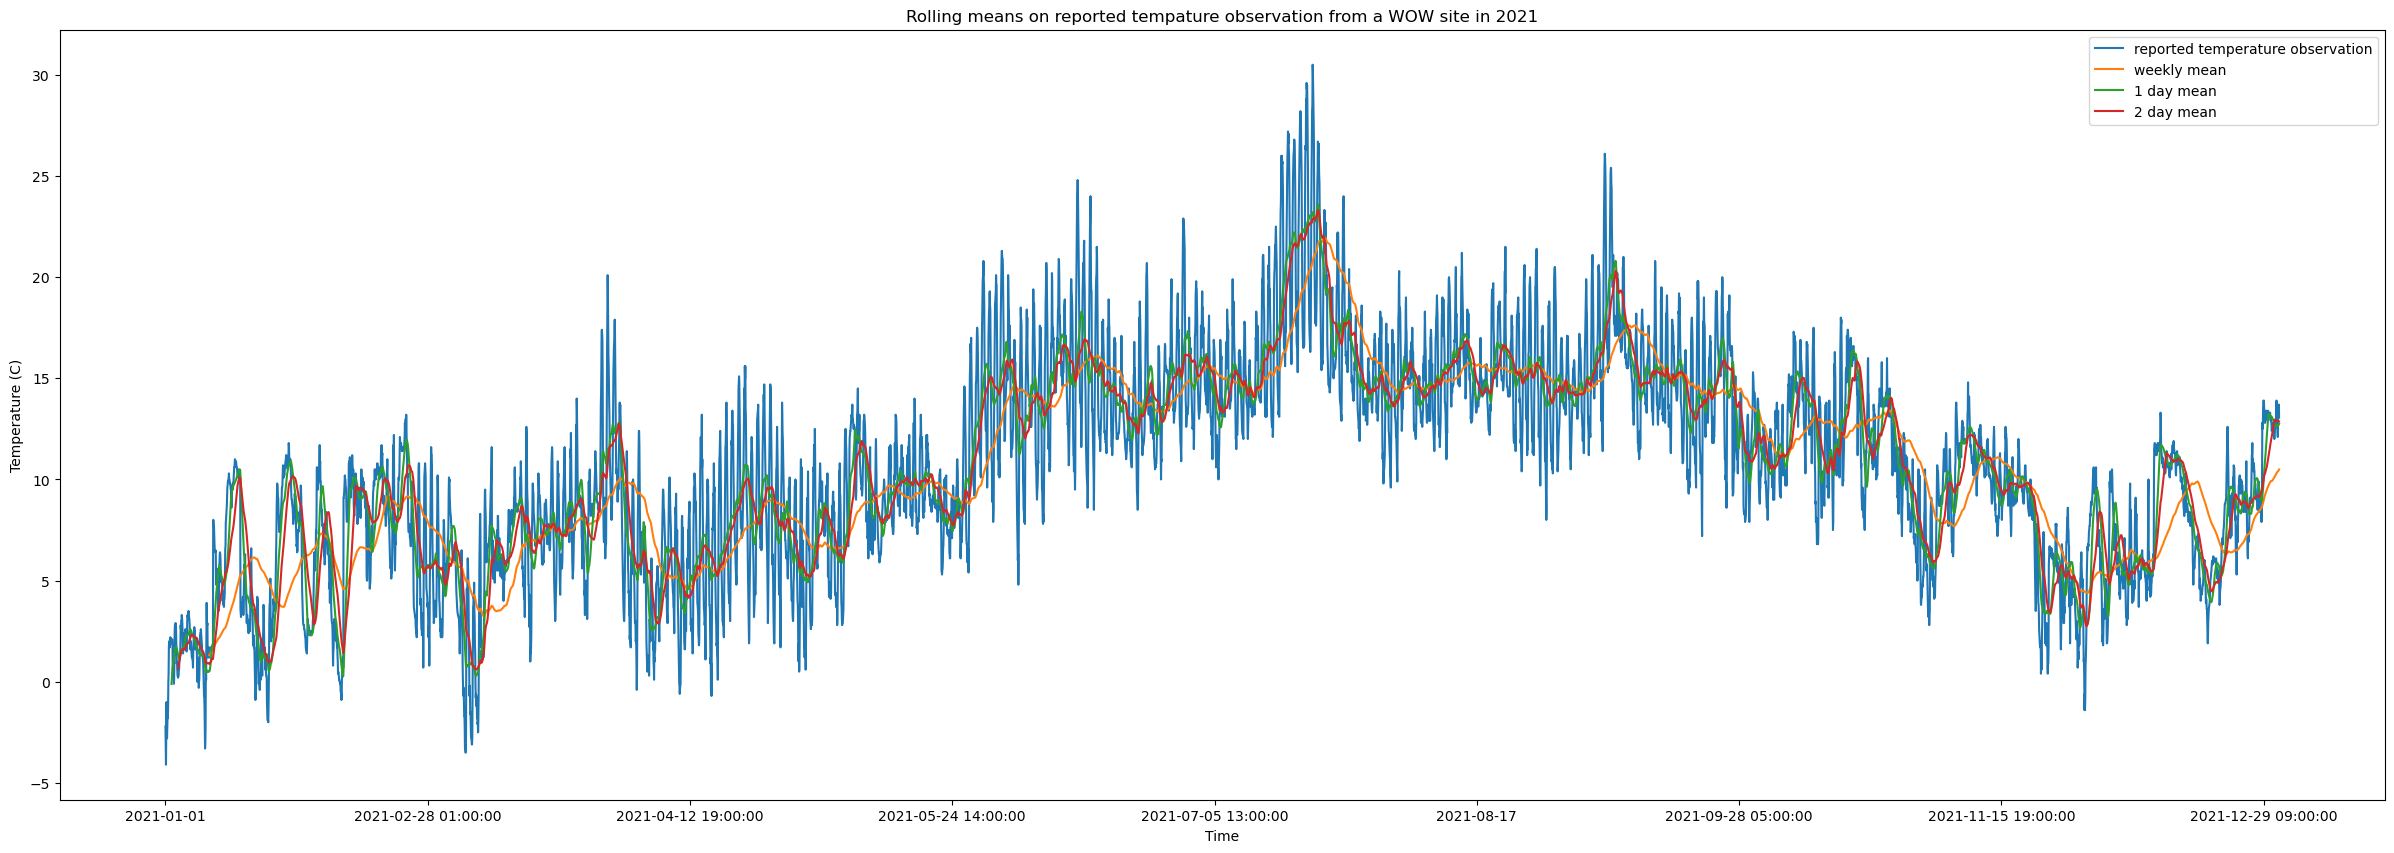

In [19]:
# plot single site data with different rolling means to make better sense of temperatures across longer timescales
plt.figure(figsize=(30, 10))
plt.plot(df["Report Date / Time"], df["Air Temperature"], label="reported temperature observation")
# 168 = 24*7 = approx the weekly average temp (inaccurate due to missing data)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(168).mean(),
    label="weekly mean",
)
# similarly 24 is a 1 day mean (due to the expted observation frequency of 1 hour)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(24).mean(),
    label="1 day mean",
)
plt.plot(
    df["Report Date / Time"],
    df["Air Temperature"].rolling(48).mean(),
    label="2 day mean",
)
number_of_samples = len(df["Report Date / Time"])
plt.xticks(np.arange(0, number_of_samples, 1000)) # the issue of overlapping dates may also be resolved through converting date strings to datetime objects, which matplotlib handles
plt.legend()
# plt.yticks([])

plt.title("Rolling means on reported tempature observation from a WOW site in 2021")
plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.show()

### Wow data, 2019 Seasonal, 5 sites across England

#### Load and Merge Data into Singular DataFrame

In [23]:
# define filepaths for multiple site data (in this case data taken from 2019 is multi site)
csv_files = glob.glob(multi_site_glob_pattern)
print(csv_files)

['data/WOW/multi_site_2019/1040_2019.csv', 'data/WOW/multi_site_2019/32_2019.csv', 'data/WOW/multi_site_2019/5018_2019.csv', 'data/WOW/multi_site_2019/7001_2019.csv', 'data/WOW/multi_site_2019/7007_2019.csv', 'data/WOW/multi_site_2019/7011_2019.csv']


In [24]:
# read and save data into dfs
list_of_dfs_from_csv = []
for csv_path in csv_files:
    df = pd.read_csv(csv_path)
    list_of_dfs_from_csv.append(df)

In [25]:
# show files loaded
print(len(list_of_dfs_from_csv))

6


In [26]:
# bring all data into a single dataframe
df = pd.concat(list_of_dfs_from_csv)
df

Unnamed: 0                                   Id  Site Id  Longitude  \
0              0  ﻿20190101ugqkeyopcye6ufdnyyb96sc9wc     1040     -2.640   
1              1   201901019zg9c3eppye6ufdnyyb96smacc     1040     -2.640   
2              2   20190101mhgjrnopqre6ufdnyyb96smacc     1040     -2.640   
3              3   20190101a7dycnopxre6ufdnyyb96smacc     1040     -2.640   
4              4   20190101fciwnmopoee6ufdnyyb96smacc     1040     -2.640   
...          ...                                  ...      ...        ...   
8514        8514   20191231kdhyf9tcboe6ibnwyyb96sptuo     7011     -0.433   
8515        8515   20191231sku7sntcnoe6ibnwyyb96sptuo     7011     -0.433   
8516        8516   20191231zr3huk3cnoe6ibnwyyb96sptuo     7011     -0.433   
8517        8517   20191231n1cjh6jcdwe6ibnwyyb96sptuo     7011     -0.433   
8518        8518   20191231q3br31tcrwe6ibnwyyb96sptuo     7011     -0.433   

      Latitude   Report Date / Time  Air Temperature  Wet Bulb  Dew Point  \
0       51.006           2019-01-01              8.8       NaN        5.8   
1       51.006  2019-01-01 01:00:00              9.0       NaN        5.6   
2       51.006  2019-01-01 02:00:00              8.8       NaN        5.8   
3       51.006  2019-01-01 03:00:00              9.0       NaN        5.6   
4       51.006  2019-01-01 04:00:00              9.2       NaN        5.6   
...        ...                  ...              ...       ...        ...   
8514    53.867  2019-12-31 19:00:00              0.5       NaN        0.5   
8515    53.867  2019-12-31 20:00:00              0.8       NaN        0.7   
8516    53.867  2019-12-31 21:00:00              0.8       NaN        0.8   
8517    53.867  2019-12-31 22:00:00              0.9       NaN        0.9   
8518    53.867  2019-12-31 23:00:00              0.9       NaN        0.9   

      Concrete Temp.  ...  v1_Coastal  v1_Flood  v1_Ice  v1_Landslide  \
0                NaN  ...         NaN       NaN     NaN           NaN   
1                NaN  ...         NaN       NaN     NaN           NaN   
2                NaN  ...         NaN       NaN     NaN           NaN   
3                NaN  ...         NaN       NaN     NaN           NaN   
4                NaN  ...         NaN       NaN     NaN           NaN   
...              ...  ...         ...       ...     ...           ...   
8514             NaN  ...         NaN       NaN     NaN           NaN   
8515             NaN  ...         NaN       NaN     NaN           NaN   
8516             NaN  ...         NaN       NaN     NaN           NaN   
8517             NaN  ...         NaN       NaN     NaN           NaN   
8518             NaN  ...         NaN       NaN     NaN           NaN   

      v1_Lightning  v1_PoorVisibility  v1_Snow  v1_Wildfire  v1_Wind  v1_Other  
0              NaN                NaN      NaN          NaN      NaN       NaN  
1              NaN                NaN      NaN          NaN      NaN       NaN  
2              NaN                NaN      NaN          NaN      NaN       NaN  
3              NaN                NaN      NaN          NaN      NaN       NaN  
4              NaN                NaN      NaN          NaN      NaN       NaN  
...            ...                ...      ...          ...      ...       ...  
8514           NaN                NaN      NaN          NaN      NaN       NaN  
8515           NaN                NaN      NaN          NaN      NaN       NaN  
8516           NaN                NaN      NaN          NaN      NaN       NaN  
8517           NaN                NaN      NaN          NaN      NaN       NaN  
8518           NaN                NaN      NaN          NaN      NaN       NaN  

[50676 rows x 62 columns]

##### Ensure no Duplicate Data has been Loaded (Manual Verification Through Cell Output)

In [27]:
# show duplicate rows, (should be none)
df[df.duplicated()]

Empty DataFrame
Columns: [Unnamed: 0, Id, Site Id, Longitude, Latitude, Report Date / Time, Air Temperature, Wet Bulb, Dew Point, Concrete Temp., Grass Temp., Min. Temp. (last 24hr), Max. Temp. (last 24hr), Soil Temp. (at 10cm), Soil Temp. (at 30cm), Soil Temp. (at 100cm), Mean Sea-Level Pressure, Pressure (At Station), Relative Humidity, Rainfall Rate, Rainfall Accumulation, Rainfall, Wind Speed, Wind Direction, Wind Gust, Wind Gust Direction, Snow Depth, Soil Moisture, Present Weather, Visibility, Total Cloud Cover, Sunshine, Ground State, Day of Thunder, Day of Gales, Day of Hail, Day of Snow, Weather Diary, Travel Disruption, Hazards causing Travel Disruption, Property or Infrastructure Damage, Hazards causing Property or Infrastructure Damage, Personal Health and Safety, Hazards causing Personal Health and Safety, Utility Disruption, Hazards causing Utility Disruption, Service or Business Disruption, Hazards causing Service or Business Disruption, Agriculture Habitat Damage, Hazards causing Agriculture Habitat Damage, Disruption to Camping Events Leisure Activities, Hazards causing Disruption to Camping Events Leisure Activities, v1_Coastal, v1_Flood, v1_Ice, v1_Landslide, v1_Lightning, v1_PoorVisibility, v1_Snow, v1_Wildfire, v1_Wind, v1_Other]
Index: []

[0 rows x 62 columns]

#### Plot Multi Site Information

In [28]:
# show the unique lon lat combinations to get the positions of unique sites
lat_lon_df = df[["Longitude", "Latitude"]]
lat_lon_df = lat_lon_df.drop_duplicates()
lat_lon_df

Longitude  Latitude
0   -2.64000  51.00600
0   -2.55300  55.05000
0   -1.97993  53.12755
0    0.45300  51.89600
0   -1.33000  52.35800
0   -0.43300  53.86700

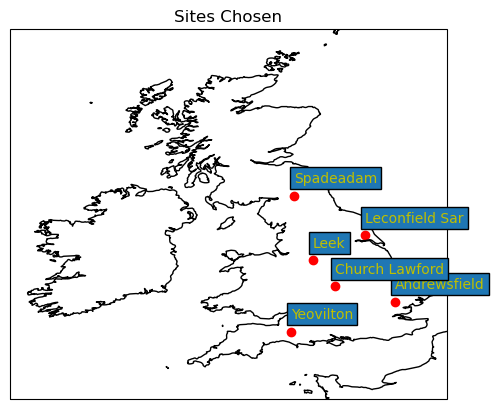

In [36]:
if PLOT_SITE_NAMES_MAP:
    try:
        # plot and annotate the site positions on a map, this wastes DataHub requests on just site names.
        # save the site names to a list
        ax = plt.axes(projection=ccrs.PlateCarree())
        plt.title("Sites Chosen")
        ax.set_extent([-11, 2, 60, 49], ccrs.PlateCarree())  # extent is uk
        plt.scatter(x=lat_lon_df["Longitude"], y=lat_lon_df["Latitude"], color="r")
        ax.coastlines()

        # possible to integrate this with met office datahub api to get location names (not obs site names)
        name_list = []
        for i, (df_ind, (lon, lat)) in enumerate(lat_lon_df.iterrows()):
            params = {
                "includeLocationName": "true",
                "latitude": str(lat),
                "longitude": str(lon),
            }
            # optionally 'waste' datahub site specific requests by getting
            request_url = (
                "https://api-metoffice.apiconnect.ibmcloud.com/v0/forecasts/point/hourly"
            )
            request = requests.get(request_url, params=params, headers=spot_data_headers)
            # the site names for each location ignoring the forecast data returned  #
            name = request.json()["features"][0]["properties"]["location"]["name"]
            name_list.append((name, lon, lat))
            plt.annotate(name, (lon, lat+0.4), c="y", bbox=dict(boxstyle="square,pad=0.3"))

        plt.show()
    except Exception as e:
        print("Something went wrong with the plot: ",e,", sorry!")

#### Prune and Format Data to Desired Data for Plotting

In [38]:
# do some data processing, drop columns with all NaNs
df.dropna(axis=1, how="all", inplace=True)
# take all rows where air temp is reported
df = df[df["Air Temperature"].notna()]
df

Unnamed: 0                                   Id  Site Id  Longitude  \
0              0  ﻿20190101ugqkeyopcye6ufdnyyb96sc9wc     1040     -2.640   
1              1   201901019zg9c3eppye6ufdnyyb96smacc     1040     -2.640   
2              2   20190101mhgjrnopqre6ufdnyyb96smacc     1040     -2.640   
3              3   20190101a7dycnopxre6ufdnyyb96smacc     1040     -2.640   
4              4   20190101fciwnmopoee6ufdnyyb96smacc     1040     -2.640   
...          ...                                  ...      ...        ...   
8514        8514   20191231kdhyf9tcboe6ibnwyyb96sptuo     7011     -0.433   
8515        8515   20191231sku7sntcnoe6ibnwyyb96sptuo     7011     -0.433   
8516        8516   20191231zr3huk3cnoe6ibnwyyb96sptuo     7011     -0.433   
8517        8517   20191231n1cjh6jcdwe6ibnwyyb96sptuo     7011     -0.433   
8518        8518   20191231q3br31tcrwe6ibnwyyb96sptuo     7011     -0.433   

      Latitude   Report Date / Time  Air Temperature  Dew Point  \
0       51.006           2019-01-01              8.8        5.8   
1       51.006  2019-01-01 01:00:00              9.0        5.6   
2       51.006  2019-01-01 02:00:00              8.8        5.8   
3       51.006  2019-01-01 03:00:00              9.0        5.6   
4       51.006  2019-01-01 04:00:00              9.2        5.6   
...        ...                  ...              ...        ...   
8514    53.867  2019-12-31 19:00:00              0.5        0.5   
8515    53.867  2019-12-31 20:00:00              0.8        0.7   
8516    53.867  2019-12-31 21:00:00              0.8        0.8   
8517    53.867  2019-12-31 22:00:00              0.9        0.9   
8518    53.867  2019-12-31 23:00:00              0.9        0.9   

      Mean Sea-Level Pressure  Relative Humidity  Wind Speed  Wind Direction  \
0                      1036.0               81.1         7.8           292.5   
1                      1035.0               78.9         9.6           292.5   
2                      1035.0               81.1         8.7           292.5   
3                      1036.0               78.9         7.0           292.5   
4                      1035.0               77.7         9.6           292.5   
...                       ...                ...         ...             ...   
8514                   1033.0              100.0         0.9           315.0   
8515                   1033.0               99.4         0.0             0.0   
8516                   1033.0              100.0         0.0             0.0   
8517                   1033.0              100.0         0.9           247.5   
8518                   1032.0              100.0         0.0             0.0   

      Wind Gust Visibility  
0           NaN        9.0  
1           NaN        9.0  
2           NaN        8.0  
3           NaN        9.0  
4           NaN        8.0  
...         ...        ...  
8514        NaN          1  
8515        NaN          1  
8516        NaN          1  
8517        NaN          0  
8518        NaN          1  

[50543 rows x 14 columns]

In [39]:
df = df.copy()
# add hour minute seconds to data that is missing this information (only at midnight)
# standardize the times (add HH:MM:SS time to days at midnight)
standard_date_series = df["Report Date / Time"].apply(
    lambda x: (x + " 00:00:00") if len(x) == 10 else x
)
df["Report Date / Time"] = standard_date_series
df

Unnamed: 0                                   Id  Site Id  Longitude  \
0              0  ﻿20190101ugqkeyopcye6ufdnyyb96sc9wc     1040     -2.640   
1              1   201901019zg9c3eppye6ufdnyyb96smacc     1040     -2.640   
2              2   20190101mhgjrnopqre6ufdnyyb96smacc     1040     -2.640   
3              3   20190101a7dycnopxre6ufdnyyb96smacc     1040     -2.640   
4              4   20190101fciwnmopoee6ufdnyyb96smacc     1040     -2.640   
...          ...                                  ...      ...        ...   
8514        8514   20191231kdhyf9tcboe6ibnwyyb96sptuo     7011     -0.433   
8515        8515   20191231sku7sntcnoe6ibnwyyb96sptuo     7011     -0.433   
8516        8516   20191231zr3huk3cnoe6ibnwyyb96sptuo     7011     -0.433   
8517        8517   20191231n1cjh6jcdwe6ibnwyyb96sptuo     7011     -0.433   
8518        8518   20191231q3br31tcrwe6ibnwyyb96sptuo     7011     -0.433   

      Latitude   Report Date / Time  Air Temperature  Dew Point  \
0       51.006  2019-01-01 00:00:00              8.8        5.8   
1       51.006  2019-01-01 01:00:00              9.0        5.6   
2       51.006  2019-01-01 02:00:00              8.8        5.8   
3       51.006  2019-01-01 03:00:00              9.0        5.6   
4       51.006  2019-01-01 04:00:00              9.2        5.6   
...        ...                  ...              ...        ...   
8514    53.867  2019-12-31 19:00:00              0.5        0.5   
8515    53.867  2019-12-31 20:00:00              0.8        0.7   
8516    53.867  2019-12-31 21:00:00              0.8        0.8   
8517    53.867  2019-12-31 22:00:00              0.9        0.9   
8518    53.867  2019-12-31 23:00:00              0.9        0.9   

      Mean Sea-Level Pressure  Relative Humidity  Wind Speed  Wind Direction  \
0                      1036.0               81.1         7.8           292.5   
1                      1035.0               78.9         9.6           292.5   
2                      1035.0               81.1         8.7           292.5   
3                      1036.0               78.9         7.0           292.5   
4                      1035.0               77.7         9.6           292.5   
...                       ...                ...         ...             ...   
8514                   1033.0              100.0         0.9           315.0   
8515                   1033.0               99.4         0.0             0.0   
8516                   1033.0              100.0         0.0             0.0   
8517                   1033.0              100.0         0.9           247.5   
8518                   1032.0              100.0         0.0             0.0   

      Wind Gust Visibility  
0           NaN        9.0  
1           NaN        9.0  
2           NaN        8.0  
3           NaN        9.0  
4           NaN        8.0  
...         ...        ...  
8514        NaN          1  
8515        NaN          1  
8516        NaN          1  
8517        NaN          0  
8518        NaN          1  

[50543 rows x 14 columns]

In [40]:
# convert data/time string to Date Time python object
str_format = "%Y-%m-%d %H:%M:%S"
df["Report Date / Time"] = df["Report Date / Time"].apply(
    lambda x: datetime.datetime.strptime(x, str_format)
)
print(df["Report Date / Time"].dtype)
df

datetime64[ns]


Unnamed: 0                                   Id  Site Id  Longitude  \
0              0  ﻿20190101ugqkeyopcye6ufdnyyb96sc9wc     1040     -2.640   
1              1   201901019zg9c3eppye6ufdnyyb96smacc     1040     -2.640   
2              2   20190101mhgjrnopqre6ufdnyyb96smacc     1040     -2.640   
3              3   20190101a7dycnopxre6ufdnyyb96smacc     1040     -2.640   
4              4   20190101fciwnmopoee6ufdnyyb96smacc     1040     -2.640   
...          ...                                  ...      ...        ...   
8514        8514   20191231kdhyf9tcboe6ibnwyyb96sptuo     7011     -0.433   
8515        8515   20191231sku7sntcnoe6ibnwyyb96sptuo     7011     -0.433   
8516        8516   20191231zr3huk3cnoe6ibnwyyb96sptuo     7011     -0.433   
8517        8517   20191231n1cjh6jcdwe6ibnwyyb96sptuo     7011     -0.433   
8518        8518   20191231q3br31tcrwe6ibnwyyb96sptuo     7011     -0.433   

      Latitude  Report Date / Time  Air Temperature  Dew Point  \
0       51.006 2019-01-01 00:00:00              8.8        5.8   
1       51.006 2019-01-01 01:00:00              9.0        5.6   
2       51.006 2019-01-01 02:00:00              8.8        5.8   
3       51.006 2019-01-01 03:00:00              9.0        5.6   
4       51.006 2019-01-01 04:00:00              9.2        5.6   
...        ...                 ...              ...        ...   
8514    53.867 2019-12-31 19:00:00              0.5        0.5   
8515    53.867 2019-12-31 20:00:00              0.8        0.7   
8516    53.867 2019-12-31 21:00:00              0.8        0.8   
8517    53.867 2019-12-31 22:00:00              0.9        0.9   
8518    53.867 2019-12-31 23:00:00              0.9        0.9   

      Mean Sea-Level Pressure  Relative Humidity  Wind Speed  Wind Direction  \
0                      1036.0               81.1         7.8           292.5   
1                      1035.0               78.9         9.6           292.5   
2                      1035.0               81.1         8.7           292.5   
3                      1036.0               78.9         7.0           292.5   
4                      1035.0               77.7         9.6           292.5   
...                       ...                ...         ...             ...   
8514                   1033.0              100.0         0.9           315.0   
8515                   1033.0               99.4         0.0             0.0   
8516                   1033.0              100.0         0.0             0.0   
8517                   1033.0              100.0         0.9           247.5   
8518                   1032.0              100.0         0.0             0.0   

      Wind Gust Visibility  
0           NaN        9.0  
1           NaN        9.0  
2           NaN        8.0  
3           NaN        9.0  
4           NaN        8.0  
...         ...        ...  
8514        NaN          1  
8515        NaN          1  
8516        NaN          1  
8517        NaN          0  
8518        NaN          1  

[50543 rows x 14 columns]

In [41]:
# take only the desired data for plots, sort data
sub_df_for_plot = df[["Site Id", "Report Date / Time", "Air Temperature"]]
sub_df_for_plot = sub_df_for_plot.sort_values(by="Report Date / Time")  # sort by date
sub_df_for_plot

Site Id  Report Date / Time  Air Temperature
0        1040 2019-01-01 00:00:00              8.8
0        7001 2019-01-01 00:00:00              8.1
0          32 2019-01-01 00:00:00              7.3
0        7007 2019-01-01 00:00:00              8.3
0        7011 2019-01-01 00:00:00              9.1
...       ...                 ...              ...
8396     7007 2019-12-31 23:00:00              7.3
8521       32 2019-12-31 23:00:00              1.6
8467     5018 2019-12-31 23:00:00              4.8
8306     7001 2019-12-31 23:00:00              7.4
8518     7011 2019-12-31 23:00:00              0.9

[50543 rows x 3 columns]

In [42]:
# drop all rows with NaN values, get a seperate dataframe per site
sub_df_for_plot = sub_df_for_plot.dropna(axis=0)
plot_by_site = dict(tuple(sub_df_for_plot.groupby("Site Id")))

In [43]:
# convert the site grouped dataframes into a list
df_list = []
for values in plot_by_site.values():
    df_list.append(pd.DataFrame(values))
df_list[0]

Site Id  Report Date / Time  Air Temperature
0          32 2019-01-01 00:00:00              7.3
1          32 2019-01-01 01:00:00              7.3
2          32 2019-01-01 02:00:00              7.4
3          32 2019-01-01 03:00:00              7.5
4          32 2019-01-01 04:00:00              7.6
...       ...                 ...              ...
8517       32 2019-12-31 19:00:00             -0.1
8518       32 2019-12-31 20:00:00             -0.7
8519       32 2019-12-31 21:00:00             -1.6
8520       32 2019-12-31 22:00:00              0.1
8521       32 2019-12-31 23:00:00              1.6

[8519 rows x 3 columns]

#### Plot Desired Data as a Whole

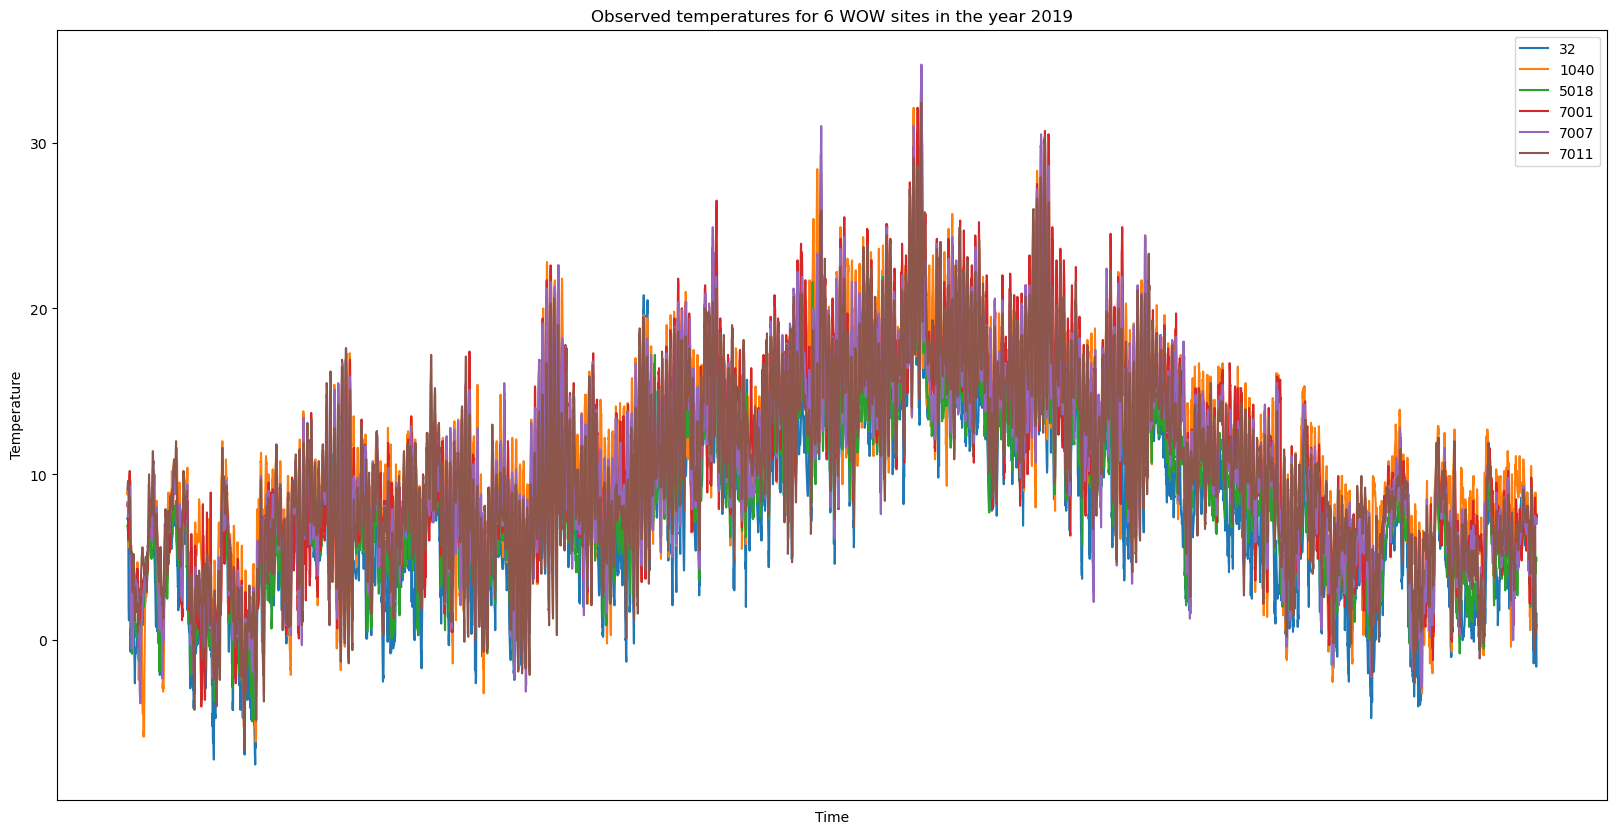

In [44]:
# plot each site into one figure
plt.figure(figsize=(20, 10))
for df in df_list:
    plt.plot(
        df["Report Date / Time"], df["Air Temperature"], label=df["Site Id"].iloc[0]
    )
plt.xticks([])
plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature (C)")
plt.title("Observed Temperatures for 6 WOW sites in the year 2019")
plt.show()

#### Separate Data by Month per Site

In [46]:
# further group data by month (grouped by site first, then month)
i = 0
for site in df_list:
    site["month"] = site["Report Date / Time"].apply(lambda x: x.month)
    seasonal = dict(tuple(site.groupby("month")))
    season_list = []
    for values in seasonal.values():
        season_list.append(pd.DataFrame(values))
    df_list[i] = season_list  # bad practice to have an array of ragged types, should create new object instead
    # print(i)
    i += 1
del i

#### Plot Separated Data in Individual Figures

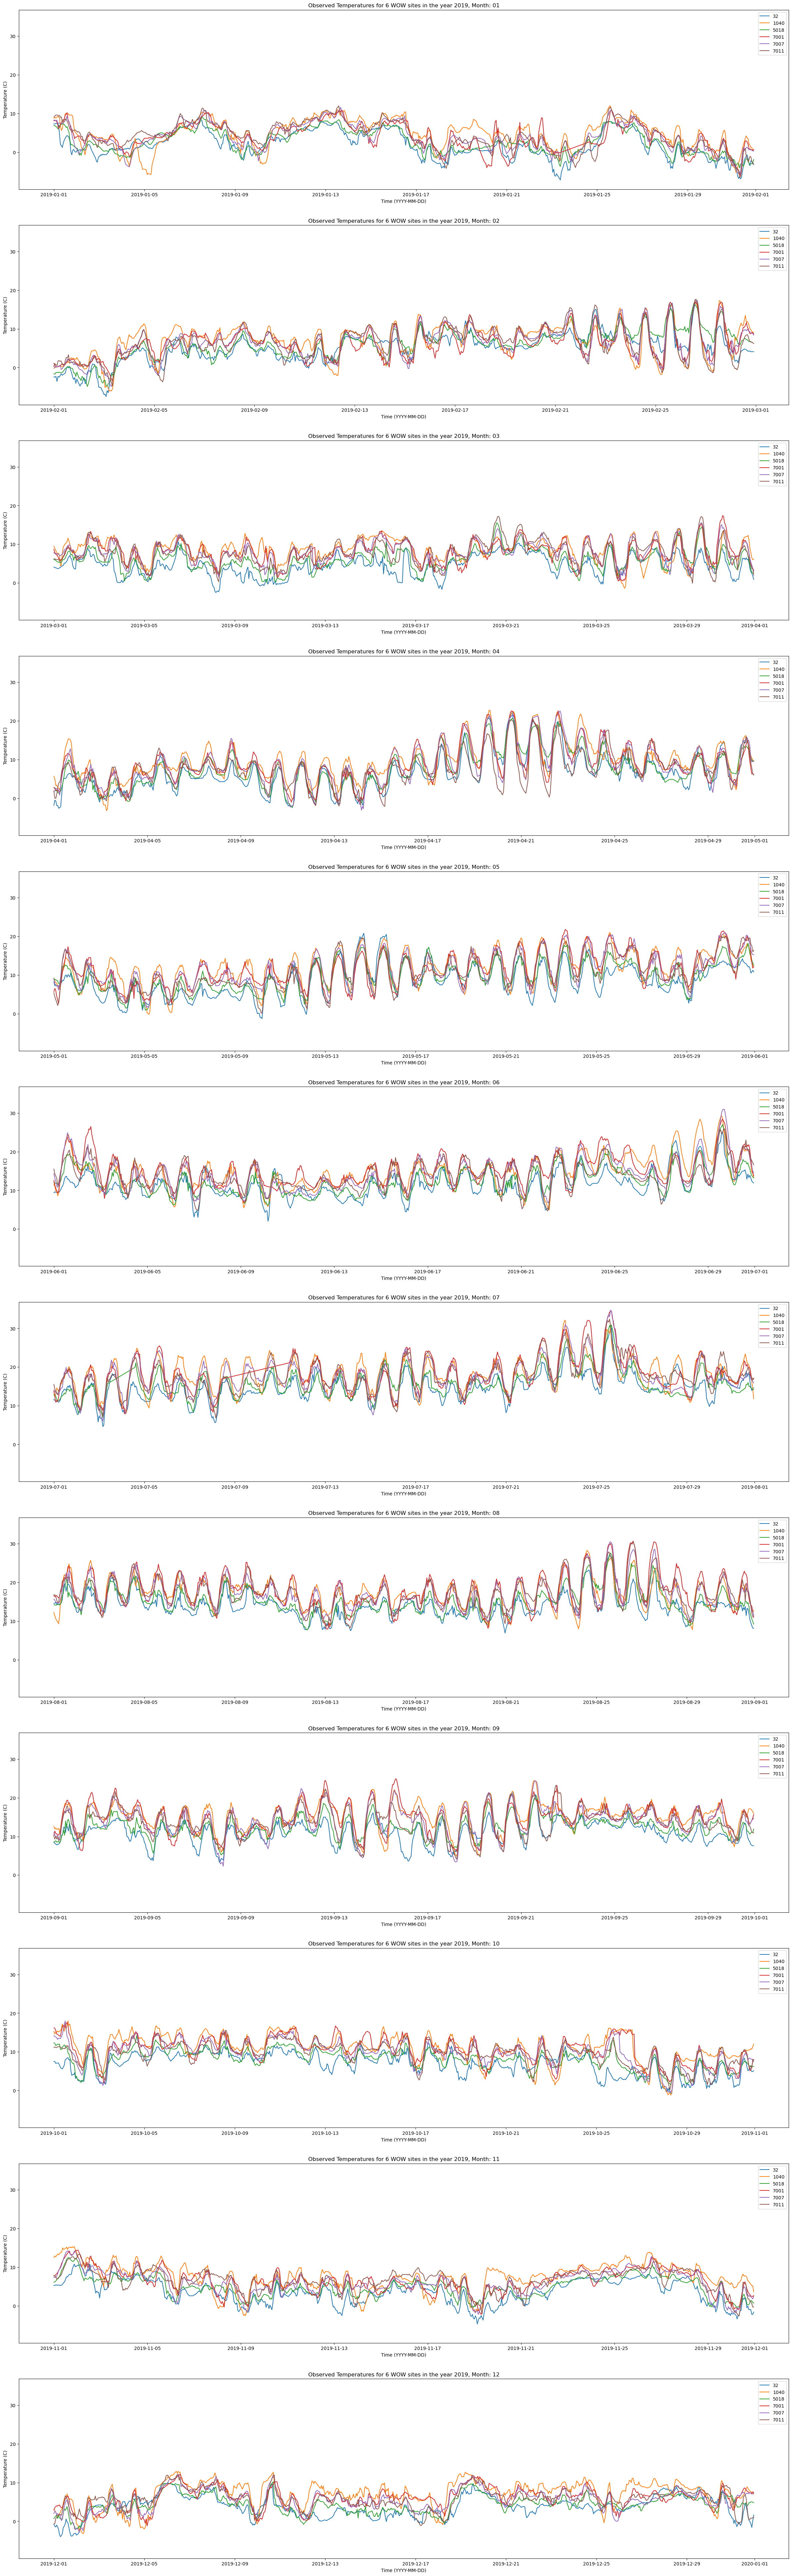

In [55]:
# plot the site, month grouping of data across month based plots
fig, axes = plt.subplots(
    nrows=len(df_list[0]), ncols=1, figsize=(30, 100), sharex=False, sharey=True
)

for i, ax in enumerate(axes.flatten()):
    for j in range(len(df_list)):
        ax.plot(
            df_list[j][i]["Report Date / Time"],
            df_list[j][i]["Air Temperature"],
            label=df_list[j][i]["Site Id"].iloc[0],
        )
        ax.set_xlabel("Time (YYYY-MM-DD)")
        ax.set_ylabel("Temperature (C)")
        title_str = "Observed Temperatures for 6 WOW sites in the year 2019, Month: " + str(df_list[j][i]["Report Date / Time"].iloc[0])[5:7]
        ax.set_title(title_str)
        ax.legend()
plt.legend()
plt.show()

## Data Statement

__Contains public sector information licensed under the Open Government Licence v3.0.__

(20th September 2022, paraphrased) When interacting with WOW data, Unless indicated otherwise, WOW data are licensed under the Open Government Licence; please see the Open Government Licence.

- Link to Open Government Licence: https://www.nationalarchives.gov.uk/doc/open-government-licence/version/3/
- Link to WOW licence: https://wow.metoffice.gov.uk/support/licence
- Source of Data: https://wow.metoffice.gov.uk

______________________________________________________________________

## References

- [WOW](https://www.wow.metoffice.gov.uk/)
- [CSV File Format](https://en.wikipedia.org/wiki/Comma-separated_values)
- [Pandas](https://pandas.pydata.org)
- [Matplotlib](https://matplotlib.org/)
- [DataHub](https://metoffice.apiconnect.ibmcloud.com/metoffice/production/)